# Comparing flip and then undistort (pipeline) vs undistort and then flip (theoretically sound)
This notebook aims to clarify if the order of the operations flip and undistort matters. The notebook does the following:
1. Sample a grid of pixels within the image bounds
2. Apply a) the flip and then undistort operation (as currently implemented in the pipeline) on the pixels and b) the undistort and then flip operation on the pixels
3. Compare the results of the two operations by visualising the the difference of where the pixels end up in the image

In [1]:
from wayve.core.data.reference_frames import ReferenceFrame
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from typing import Dict, Union, Tuple, List
from dataclasses import dataclass
import json

# Some figures paths and options
FIGURES_DIR = Path("/home/benjin/Development/wcs/intrinsics/logs/notebooks/figures/")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
IMG_DIR = Path("/home/benjin/Development/wcs/intrinsics/logs/notebooks/data/ebro/")

VEHICLE_REPORT_FILE = Path('/home/benjin/Development/wcs/intrinsics/wayve/services/calibration/camera_intrinsics/raw_entron_intrinsics') / "ebro.json"
if not VEHICLE_REPORT_FILE.exists():
    raise FileNotFoundError(f"Vehicle report file {VEHICLE_REPORT_FILE} does not exist")

# The images are supposed to be the raw images from the camera
# They are the images in the blob storage, but reverse-indexing was turned off
IMG_FILEPATHS = list(IMG_DIR.glob("*.png"))
STEP_SIZE = 100 # Step size for the sampled pixels (0, 0), (0, STEP_SIZE), etc

@dataclass
class Intrinsics:
    K: np.ndarray
    d: np.ndarray

    def __repr__(self):
        return f"fx: {self.K[0, 0]:.3f}, fy: {self.K[1, 1]:.3f}, cx: {self.K[0, 2]:.3f}, cy: {self.K[1, 2]:.3f},\nk1: {self.d[0]:.3f}, k2: {self.d[1]:.3f}, k3: {self.d[2]:.3f}, k4: {self.d[3]:.3f}"

In [2]:
# Load a sample image and visualise
def visualise_img(img: Union[np.ndarray, Path]):
    if isinstance(img, Path):
        img = cv2.imread(str(img))
    plt.figure(figsize=(10,15))
    plt.title('Sample Image')
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()
    plt.close()

In [32]:
def get_entron_raw_intrinsics(eol_report_path: Path) -> Dict[str, Intrinsics]:
    with open(eol_report_path, "r") as f:
        data = json.load(f)

    raw_entron_intrinsics = {}
    for camera_metadata in data["cameraInfo"]:
        camera_name = ReferenceFrame.from_string(camera_metadata["name"])

        intr_dict = json.loads(camera_metadata["info"]["pin hole intrinsics"])

        K = np.array(
            [
                [intr_dict["fx"], 0, intr_dict["cx"]],
                [0, intr_dict["fy"], intr_dict["cy"]],
                [0, 0, 1]
            ]
        )
        d = np.array([intr_dict["k1"], intr_dict["k2"], intr_dict["k3"], intr_dict["k4"]])
        raw_entron_intrinsics[camera_name] = Intrinsics(K, d)

    return raw_entron_intrinsics

entron_raw_intrinsics = get_entron_raw_intrinsics(VEHICLE_REPORT_FILE)[ReferenceFrame.CameraLeftForward]

entron_raw_intrinsics = get_entron_raw_intrinsics(VEHICLE_REPORT_FILE)[ReferenceFrame.CameraFrontForward]


In [33]:
def sample_pixels_from_img(img_path: Path, step_size: int) -> List[Tuple[int, int]]:
    # Read the image
    img = cv2.imread(str(img_path))
    
    # Get the height and width of the image
    h, w, _ = img.shape
    breakpoint()
    
    # Generate the range of pixel coordinates based on the step size
    y_range = np.arange(0, h, step_size)
    x_range = np.arange(0, w, step_size)
    
    # Create a meshgrid from the coordinate ranges
    x_coords, y_coords = np.meshgrid(y_range, x_range)
    
    # Flatten the meshgrid to get pairs of coordinates
    pixel_coords = np.stack((x_coords, y_coords), axis=-1).reshape(-1, 2)
    
    # Convert pixels to format x, y
    return pixel_coords[:, ::-1]

pixels = sample_pixels_from_img(IMG_FILEPATHS[0], STEP_SIZE)
print(pixels)


[[   0    0]
 [   0  100]
 [   0  200]
 ...
 [3800 1900]
 [3800 2000]
 [3800 2100]]


In [34]:
def undistort(pixels: np.ndarray, intrinsics: Intrinsics) -> np.ndarray:
    pixels = pixels.reshape(1, -1, 2).astype(np.float32)

    # 1 What is the expected input to distorted
    # 2 What is the expected input to R (Rectification transformation in the object space)
    # 3 What is the expected input to P (New camera matrix or new projection matrix)
    # 4 How should I set the termination criteria
    undistorted_pixels = cv2.fisheye.undistortPoints(
        distorted=pixels, # Unclear if this function expects pixels or normalised pixels, it says "object points" in the doc
        K=intrinsics.K,
        D=intrinsics.d,
        P=intrinsics.K,
        criteria=(cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 200, 1e-6) # Unclear to me how they need to be set
    ).reshape(-1, 2)
    
    return undistorted_pixels

def undistort_and_flip(pixels: np.ndarray, intrinsics: Intrinsics, img_shape: Tuple[int, int]) -> np.ndarray:
    pixels = pixels.reshape(1, -1, 2).astype(np.float32)

    # 1 What is the expected input to distorted
    # 2 What is the expected input to R (Rectification transformation in the object space)
    # 3 What is the expected input to P (New camera matrix or new projection matrix)
    # 4 How should I set the termination criteria
    undistorted_pixels = cv2.fisheye.undistortPoints(
        distorted=pixels, # Unclear if this function expects pixels or normalised pixels, it says "object points" in the doc
        K=intrinsics.K,
        D=intrinsics.d,
        P=intrinsics.K,
        criteria=(cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 200, 1e-6) # Unclear to me how they need to be set
    ).reshape(-1, 2)

    # Some of the undistorted pixels end up at -1e6, -1e6. I don't understand why, these
    # pixels will be ignored with the img_boundary_filter
    
    # Flip the image
    height = img_shape[0]
    width = img_shape[1]
    undistorted_pixels[:, 0] = width - undistorted_pixels[:, 0]
    undistorted_pixels[:, 1] = height - undistorted_pixels[:, 1]
    
    return undistorted_pixels

def flip_and_undistort(pixels: np.ndarray, intrinsics: Intrinsics, img_shape: Tuple[int, int]) -> np.ndarray:
    # Flip the image
    height = img_shape[0]
    width = img_shape[1]
    pixels[:, 0] = width - pixels[:, 0]
    pixels[:, 1] = height - pixels[:, 1]
    
    # Flip the intrinsics
    old_K = intrinsics.K
    new_K = old_K.copy()
    new_K[0][2] = width - old_K[0][2]
    new_K[1][2] = height - old_K[1][2]
    
    # Undistort the pixel coordinates
    undistorted_pixels = cv2.fisheye.undistortPoints(
        distorted=pixels.reshape(1, -1, 2).astype(np.float32),
        K=new_K,
        D=intrinsics.d,
        P=new_K,
        criteria=(cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 200, 1e-6)
    ).reshape(-1, 2)
    
    return undistorted_pixels

sample_img = cv2.imread(str(IMG_FILEPATHS[0]))
H, W, C = sample_img.shape

undistorted_and_flipped_pixels = undistort_and_flip(pixels, entron_raw_intrinsics, (H, W))
flipped_and_undistorted_pixels = flip_and_undistort(pixels, entron_raw_intrinsics, (H, W))

only_undistorted_pixels = undistort(pixels, entron_raw_intrinsics)

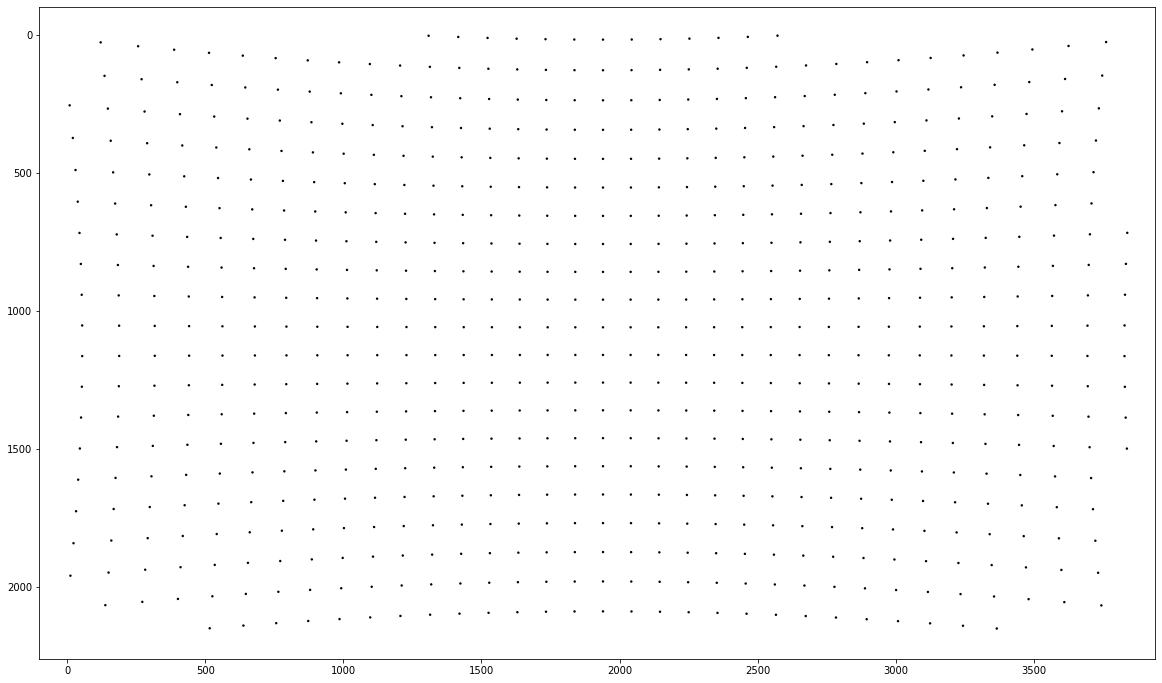

In [35]:
def visualise_pixel_diff(start_px: np.ndarray, end_px: np.ndarray, img_shape: Tuple[int, int]):
    h, w = img_shape

    # Filter problematic pixels that fall outside of the image boundary
    img_boundary_filter_1 = (0 < start_px[:,1]) & (start_px[:,1] < h) & (0 < start_px[:,0]) & (start_px[:,0] < w)
    img_boundary_filter_2 = (0 < end_px[:,1]) & (end_px[:,1] < h) & (0 < end_px[:,0]) & (end_px[:,0] < w)
    joint_img_boundary_filter = img_boundary_filter_1 & img_boundary_filter_2

    start_px = start_px[joint_img_boundary_filter]
    end_px = end_px[joint_img_boundary_filter]

    plt.figure(figsize=(20, 30))
    x_start = start_px[:, 0]
    y_start = start_px[:, 1]
    x_end = end_px[:, 0]
    y_end = end_px[:, 1]
    plt.quiver(x_start, y_start, x_end - x_start, y_end - y_start, angles='xy', scale_units='xy', scale=1)

    # plt.title('Pixel Differences: undistort and flip vs flip and undistort')
    border = 100
    plt.xlim(0 - border, W + border)
    plt.ylim(H + border, 0 - border)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    plt.close()

# visualise_pixel_diff(only_undistorted_pixels, pixels, (H, W))

visualise_pixel_diff(undistorted_and_flipped_pixels, flipped_and_undistorted_pixels, (H, W))

In [36]:
pixel_diff = (undistorted_and_flipped_pixels - flipped_and_undistorted_pixels)
avg_pixel_mvmnt = np.linalg.norm(pixel_diff, axis=1).mean()
print(f"Average pixel movement: {avg_pixel_mvmnt:.3f}")

Average pixel movement: 0.000
